# [Take-home Exercise4.1]
# Write your own ResNet-34 modules and fine-tune on CIFAR-10
---
## Readme
 - You can find a `[TODO]` label in this Homework by pressing **Ctrl + F** and entering `[TODO]` to search.
 - Goals:
   - Build ResNet-34 blocks from scratch.
   - Evaluate on CIFAR-10 (quantitative + qualitative).
   - Load and compare two checkpoints: ResNet-18 (Fine-tune on CIFAR-10) vs. ResNet-34 (Fine-tune on CIFAR-10).
   - Visualize feature maps.
   - Analyze which model is better and why?
 - We provide:
    1. the notebook `(Take-home)Exercise4.1.ipynb`
    2. the model architecture `ResNet-34_architecture.png`
    3. the checkpoint `resnet18_cifar10.pth`
 - Refer to the Example first, then come back to complete this exercise

### 1) Install the torchinfo package

In [1]:
!pip -q install torchinfo

### 2) Download the ResNet-18 checkpoint

In [2]:
!gdown 1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV

Downloading...
From (original): https://drive.google.com/uc?id=1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV
From (redirected): https://drive.google.com/uc?id=1ot6m82KgUslEX1LCBLNWWq1pfIcf-ZcV&confirm=t&uuid=b83cc9ce-41f1-4efd-a621-bc40d4150e73
To: /content/resnet18_cifar10.pth
100% 44.8M/44.8M [00:01<00:00, 31.0MB/s]


### 3) Imports Packages

In [3]:
import numpy as np
import seaborn as sns
from tqdm import tqdm
from typing import Optional
import os, math, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchinfo import summary
import torchvision
from torchvision import transforms, datasets
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models.feature_extraction import create_feature_extractor

import matplotlib.pyplot as plt

from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device =", device)

Device = cuda


### 4) Config, Seed

In [4]:
# ============================================================
# [TODO] Set up seed, and set batch size=128, epoch=3, LR=1e-4
# ============================================================
SEED = 42 # [TODO]

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

BATCH_SIZE   = 128 # [TODO]
EPOCHS     = 3 # [TODO]
LR       = 1e-4 # [TODO]
FINETUNE_ALL  = True

### 4) Data Process (CIFAR-10)

In [5]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

root = "./data"
train_set = datasets.CIFAR10(root=root, train=True, download=True, transform=train_tfms)
test_set  = datasets.CIFAR10(root=root, train=False, download=True, transform=test_tfms)
classes = train_set.classes

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Train set: ", len(train_set))
print("Test set: ", len(test_set))
print("class number: ", len(classes))
print(classes)

100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


Train set:  50000
Test set:  10000
class number:  10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 5) Load & Fine-tune ResNet34 (ImageNet-pretrained)

In [6]:
# -----------------------------
# BasicBlock (2x 3x3 conv)
# -----------------------------
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes: int, planes: int, stride: int = 1, downsample: Optional[nn.Module] = None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)   # [TODO] conv1: 3x3, stride=stride, padding=1, bias=False
        self.bn1 = nn.BatchNorm2d(planes)   # [TODO] bn1
        self.relu = nn.ReLU(inplace=True)   # [TODO] relu
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)    # [TODO] conv2: 3x3, stride=1, padding=1, bias=False
        self.bn2 = nn.BatchNorm2d(planes)   # [TODO] bn2
        self.downsample = downsample        # [TODO] store downsample module

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x
        # [TODO]
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

In [7]:
# -----------------------------
# ResNet-18
# -----------------------------
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes: int = 10):
        super().__init__()
        self.inplanes = 64
        # [TODO] stem must be 7x7, stride=2, padding=3, bias=False; then BN+ReLU+MaxPool(3,2,1)
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # [TODO] layers (2,2,2,2) with channel 64/128/256/512 and appropriate strides
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # [TODO] fc should output 10 classes (in_features=512*block.expansion)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes: int, blocks: int, stride: int = 1):
        downsample = None
        # [TODO] create downsample if stride!=1 or inplanes!=planes*expansion (1x1 conv + BN)
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                # [TODO]
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample)) # Not [TODO], but important.
        self.inplanes = planes * block.expansion # Not [TODO], but important.
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes)) # Not [TODO], but important.
        return nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # [TODO] stem forward: conv1->bn1->relu->maxpool
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # [TODO] stem forward: layer1->layer2->layer3->layer4
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # [TODO] stem forward: avgpool->flatten->fc
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### 7) Load ResNet34 checkpoint

In [9]:
pretrained_model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

# follow the architeture
model = ResNet(BasicBlock, [3, 4, 6, 3], num_classes=1000).to(device)

model.load_state_dict(pretrained_model.state_dict())

print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model.fc = nn.Linear(model.fc.in_features, len(classes)) # [TODO]
model = model.to(device)

if not FINETUNE_ALL:
    for p in model.parameters():
        p.requires_grad = False # [TODO]
    for p in model.fc.parameters():
        p.requires_grad = True # [TODO]

optimizer = torch.optim.Adam(model.parameters(), lr=LR) # [TODO]
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) # [TODO]
criterion = nn.CrossEntropyLoss() # [TODO]

print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 6) Train / Eval Loops

In [13]:
def train_one_epoch(model, loader, optimizer, criterion):
    # [TODO]
    model.train()
    total_loss, total_correct, total_num = 0.0, 0, 0
    for imgs, labels in tqdm(loader, desc="Train", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad() # [TODO]
        logits = model(imgs)  # [TODO]
        loss = criterion(logits, labels)  # [TODO]
        loss.backward() # [TODO]
        optimizer.step() # [TODO]

        total_loss += loss.item() * imgs.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_num += imgs.size(0)
    return total_loss/total_num, total_correct/total_num

# [TODO]
def evaluate(model, loader, criterion):
    # [TODO]
    model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0
    all_probs, all_labels = [], []
    for imgs, labels in tqdm(loader, desc="Eval", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)

        total_loss += loss.item() * imgs.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_num += imgs.size(0)

        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return total_loss/total_num, total_correct/total_num, all_probs, all_labels

### 7) Train

In [14]:
history = {"train_loss":[], "val_loss":[], "val_acc":[]}
best_acc = 0.0
save_path = "resnet34_cifar10.pth" # [TODO]

for epoch in range(1, EPOCHS+1):
    print(f"\n[Epoch {epoch}/{EPOCHS}]")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_probs, val_labels = evaluate(model, test_loader, criterion)

    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {tr_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"✅ Best so far. Saved to {save_path}")

print("Done. Best Val Acc =", f"{best_acc*100:.2f}%")


[Epoch 1/3]


Train Loss: 1.1010 | Val Loss: 0.7441 | Val Acc: 74.41%
✅ Best so far. Saved to resnet34_cifar10.pth

[Epoch 2/3]


Train Loss: 0.7046 | Val Loss: 0.6575 | Val Acc: 77.07%
✅ Best so far. Saved to resnet34_cifar10.pth

[Epoch 3/3]


Train Loss: 0.6671 | Val Loss: 0.6504 | Val Acc: 77.33%
✅ Best so far. Saved to resnet34_cifar10.pth
Done. Best Val Acc = 77.33%


### 8) Loss Curve

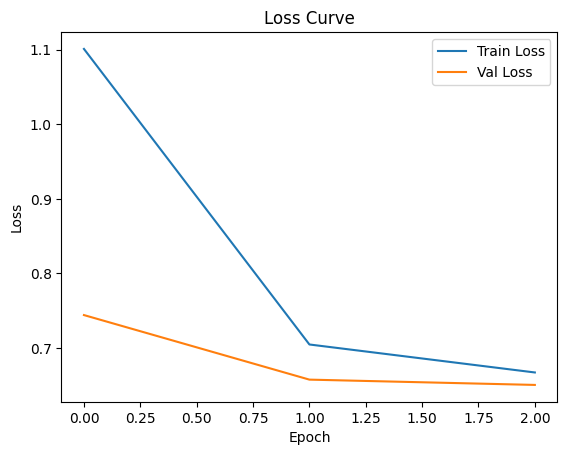

In [15]:
plt.figure()
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
plt.legend(); plt.show()

### 9) Precision–Recall Curves

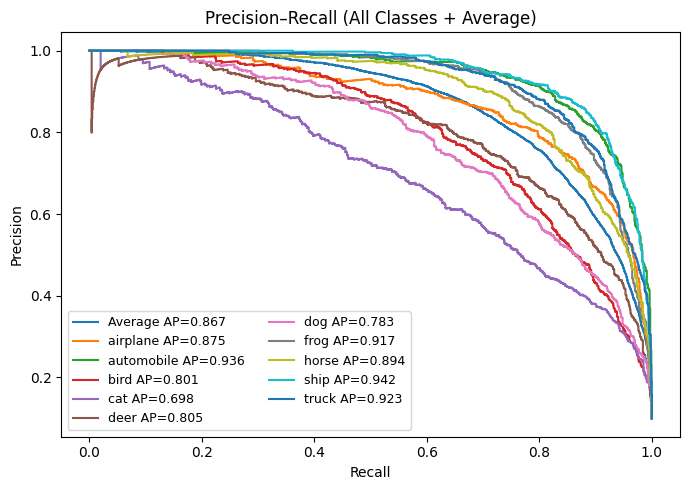

In [16]:
y_true = val_labels
y_score = val_probs
n_classes = len(classes)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
precision, recall, ap = {}, {}, {}

micro_p, micro_r, _ = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
ap_micro = average_precision_score(y_true_bin, y_score, average="micro")

plt.figure(figsize=(7,5))
plt.step(micro_r, micro_p, where='post', label=f"Average AP={ap_micro:.3f}")

aps = []
for i in range(n_classes):
    p, r, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_score[:, i])
    aps.append(ap)
    plt.step(r, p, where='post', label=f"{classes[i]} AP={ap:.3f}")

plt.xlabel("Recall"); plt.ylabel("Precision");
plt.title("Precision–Recall (All Classes + Average)")
plt.legend(ncol=2, fontsize=9, loc='lower left')
plt.tight_layout(); plt.show()

### 10) Report & Confusion Matrix

== Classification Report ==
              precision    recall  f1-score   support

    airplane      0.764     0.818     0.790      1000
  automobile      0.858     0.843     0.851      1000
        bird      0.740     0.688     0.713      1000
         cat      0.627     0.602     0.614      1000
        deer      0.694     0.752     0.722      1000
         dog      0.704     0.688     0.696      1000
        frog      0.808     0.857     0.832      1000
       horse      0.815     0.801     0.808      1000
        ship      0.875     0.858     0.866      1000
       truck      0.849     0.826     0.837      1000

    accuracy                          0.773     10000
   macro avg      0.773     0.773     0.773     10000
weighted avg      0.773     0.773     0.773     10000



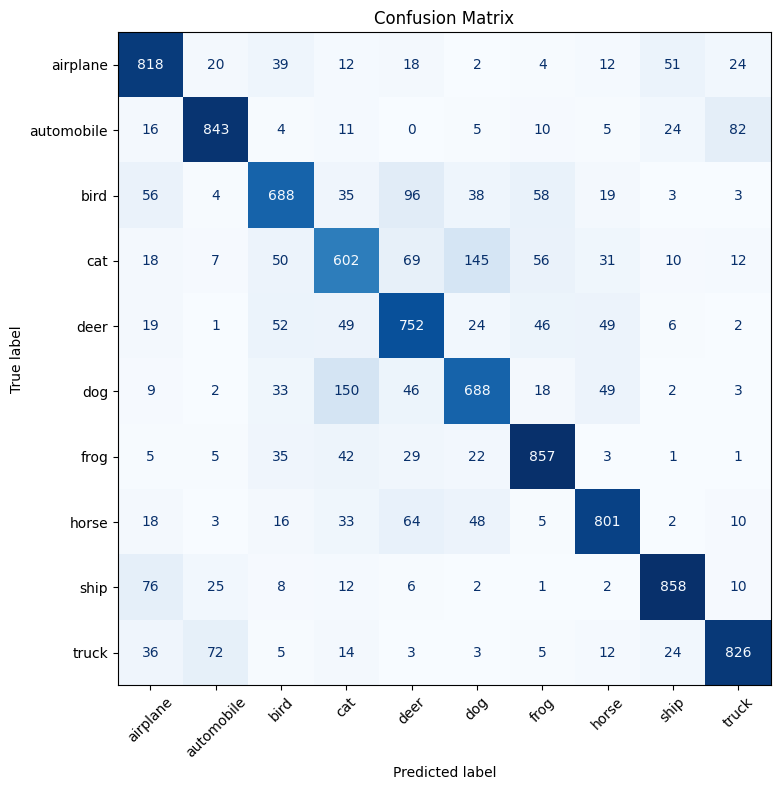

In [17]:
y_pred = np.argmax(y_score, axis=1)
print("== Classification Report ==")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### 11) Visualization: Feature Maps
 - ResNet34: conv1 / layer1 / layer2 / layer3 / layer4
 - Visualize channel-mean heatmaps over the denormalized image

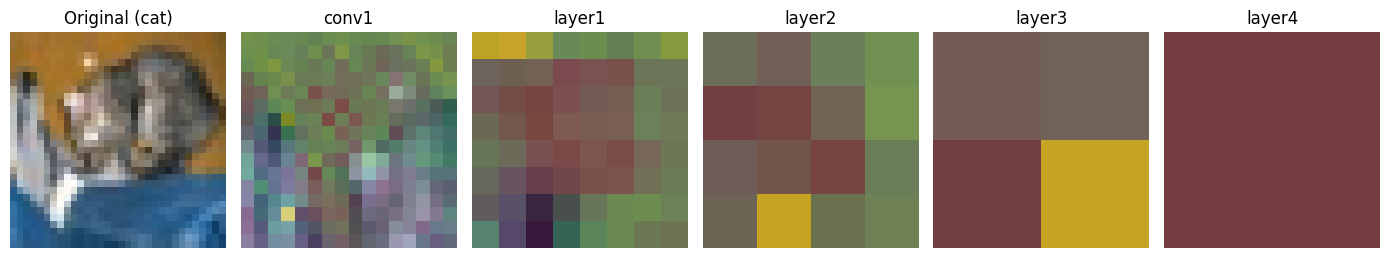

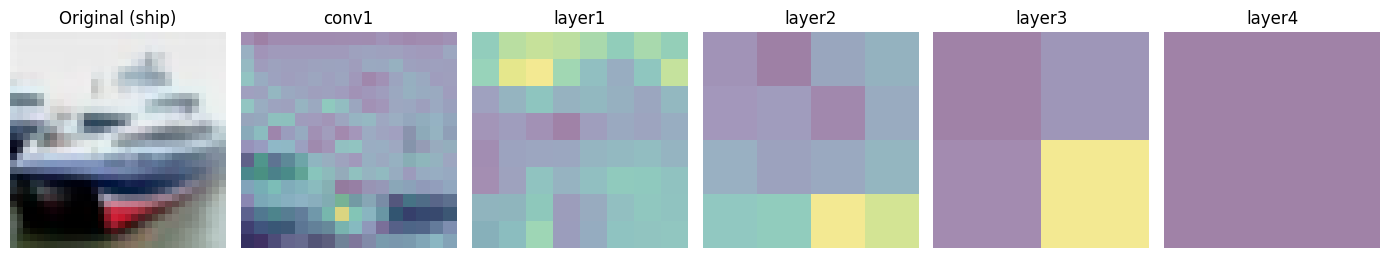

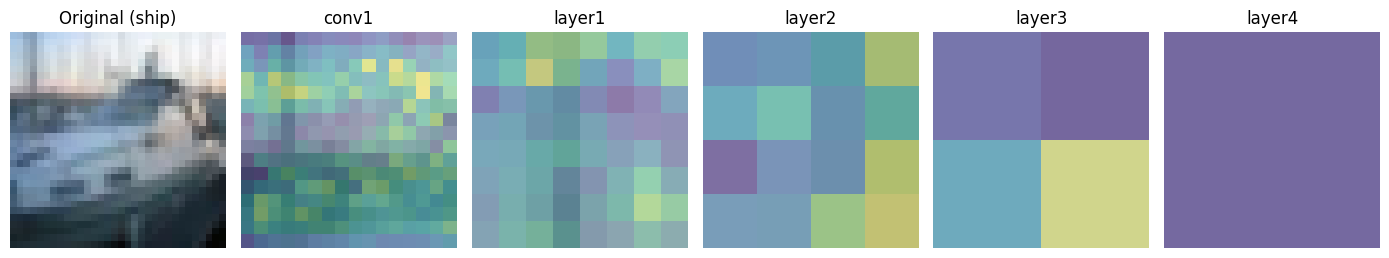

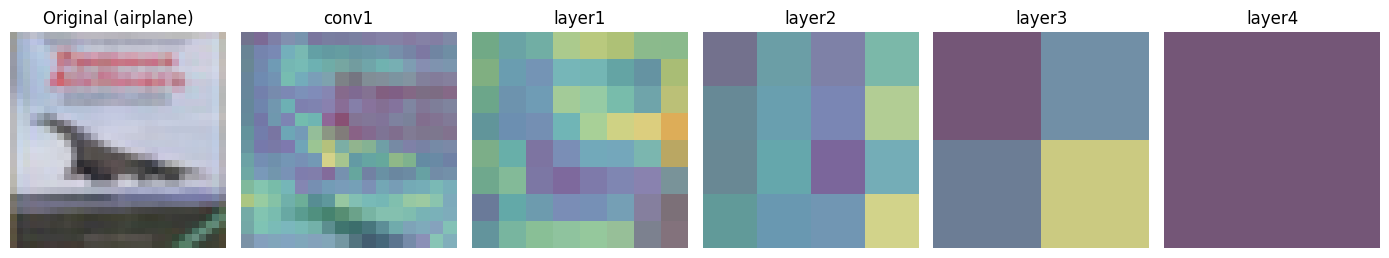

In [18]:
def denorm(img_t):
  mean = torch.tensor(IMAGENET_MEAN).view(3,1,1).to(img_t.device)
  std = torch.tensor(IMAGENET_STD).view(3,1,1).to(img_t.device)
  x = img_t * std + mean
  return x.clamp(0,1)

def _norm_map(m):
    m = m - m.min()
    m = m / (m.max() + 1e-6)
    return m

N_SHOW = 4 # [TODO]
first_batch_imgs, first_batch_labels = next(iter(test_loader))
sample_imgs_tensor = first_batch_imgs[:N_SHOW].to(device)

# ----- ResNet18 overlays -----
resnet_nodes  = {"conv1": "R_conv1", "layer1.0.relu": "R_l1", "layer2.0.relu": "R_21", "layer3.0.relu": "R_31", "layer4.0.relu": "R_41"}# [TODO]
resnet_titles = ["conv1","layer1","layer2","layer3","layer4"]
resnet_feat = create_feature_extractor(model, return_nodes=resnet_nodes).to(device).eval()

with torch.no_grad():
    r_feats = resnet_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["R_conv1","R_l1","R_21","R_31","R_41"], start=2):
        fmap = r_feats[key][i].detach().cpu()       # (C,H,W)
        heat = _norm_map(fmap.mean(0)).numpy()      # channel-mean
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(resnet_titles[j-2])
    plt.tight_layout(); plt.show()

### 12) Load & eval ResNet18 checkpoint

In [19]:
# [TODO]
def evaluate(model, loader, criterion):
    # [TODO]
    model.eval()
    total_loss, total_correct, total_num = 0.0, 0, 0
    all_probs, all_labels = [], []
    for imgs, labels in tqdm(loader, desc="Eval", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)

        total_loss += loss.item() * imgs.size(0)
        total_correct += (logits.argmax(1) == labels).sum().item()
        total_num += imgs.size(0)

        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        all_probs.append(probs)
        all_labels.append(labels.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return total_loss/total_num, total_correct/total_num, all_probs, all_labels

In [20]:
R18_model = resnet18(num_classes=len(classes)).to(device) # [TODO]

ckpt_path = "resnet18_cifar10.pth" # [TODO]  # replace with your actual checkpoint path
try:
    state = torch.load(ckpt_path, map_location='cpu')
    sd = state.get('state_dict', state)
    R18_model.load_state_dict(sd, strict=False)
    print(f'Loaded checkpoint from: {ckpt_path}')
except Exception as e:
    print(f'[WARN] Failed to load checkpoint: {e}')
    print('Proceeding with randomly initialized weights...')

#R18_model.eval()

print(summary(R18_model, input_size=(1, 3, 32, 32)))

_, R18_acc, _, _ = evaluate(R18_model, test_loader, criterion)
print(f"ResNet-18_acc Test Acc = {R18_acc*100:.2f}%")

Loaded checkpoint from: resnet18_cifar10.pth
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─BasicBlock: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6     

ResNet-18_acc Test Acc = 16.92%


### 13) Compare ResNet18 & ResNet34 (params, accuracy, inference speed)

In [30]:
R34_model = resnet34(weights=None)
R34_model.fc = nn.Linear(R34_model.fc.in_features, 10)
R34_model.load_state_dict(torch.load("resnet34_cifar10.pth", map_location=device))
R34_model = R34_model.to(device).eval()

def measure_infer_time(model, loader, max_batches=10):
    model.eval()
    nimg, t0 = 0, time.time()
    with torch.no_grad():
        for bi, (imgs, _) in enumerate(loader):
            if bi >= max_batches: break
            imgs = imgs.to(device)
            _ = model(imgs)
            nimg += imgs.size(0)
    t1 = time.time()
    ms_per_img = (t1 - t0) / max(nimg,1) * 1000.0
    return ms_per_img

ms_resnet18 = measure_infer_time(R18_model, test_loader, max_batches=10) # [TODO]
ms_resnet34 = measure_infer_time(R34_model, test_loader, max_batches=10) # [TODO]

params_resnet18 = sum(p.numel() for p in R18_model.parameters()) # [TODO]
params_resnet34 = sum(p.numel() for p in R34_model.parameters()) # [TODO]

print("\n== Model Comparison ==")
print(f"ResNet18 Params: {params_resnet18/1e6:.2f} M | Test Acc: {R18_acc*100:.2f}% | Inference: {ms_resnet18:.2f} ms/img")
print(f"ResNet34 Params: {params_resnet34/1e6:.2f} M | Test Acc: {best_acc*100:.2f}% | Inference: {ms_resnet34:.2f} ms/img")


== Model Comparison ==
ResNet18 Params: 11.18 M | Test Acc: 16.92% | Inference: 0.35 ms/img
ResNet34 Params: 21.29 M | Test Acc: 77.33% | Inference: 0.38 ms/img


### 14) Divergent sample gallery
 - Show GT / ResNet18 pred(conf) / ResNet34 pred(conf) side-by-side
 - Uses the same test_loader and denorm as above

In [25]:
MAX_VIS = 1000

# [TODO]
def collect_preds_and_images(resnet18, resnet34, loader, max_images=MAX_VIS):
    # eval both model
    R18_model.eval() # [TODO];
    R34_model.eval() # [TODO]

    r_pred18, r_conf18, r_pred34, r_conf34, y_true, imgs = [], [], [], [], [], []
    seen = 0
    with torch.no_grad():
      for imgs_b, labels in tqdm(loader, desc="Collect (for qualitative analysis)", leave=False):
          imgs_b_gpu = imgs_b.to(device)

          # ResNet18
          logits_r18 = R18_model(imgs_b_gpu)
          probs_r18 = F.softmax(logits_r18, dim=1)
          conf_r18, pred_r18 = probs_r18.max(1)

          # ResNet34
          logits_r34 = R34_model(imgs_b_gpu)
          probs_r34 = F.softmax(logits_r34, dim=1)
          conf_r34, pred_r34 = probs_r34.max(1)

          r_pred18.append(pred_r18.cpu().numpy());   r_conf18.append(conf_r18.cpu().numpy())
          r_pred34.append(pred_r34.cpu().numpy());   r_conf34.append(conf_r34.cpu().numpy())
          y_true.append(labels.numpy())

          # Cache denormalized images for display (up to max_images)
          for i in range(imgs_b.size(0)):
              if seen >= max_images: break
              img_den = denorm(imgs_b[i]).permute(1,2,0).cpu().numpy()
              imgs.append(img_den); seen += 1
          if seen >= max_images:
              break

    r_pred18 = np.concatenate(r_pred18)[:seen]
    r_conf18 = np.concatenate(r_conf18)[:seen]
    r_pred34 = np.concatenate(r_pred34)[:seen]
    r_conf34 = np.concatenate(r_conf34)[:seen]
    y_true = np.concatenate(y_true)[:seen]
    return r_pred18, r_conf18, r_pred34, r_conf34, y_true, imgs

r_pred18, r_conf18, r_pred34, r_conf34, y_true_arr, vis_imgs = collect_preds_and_images(R18_model, R34_model, test_loader, max_images=MAX_VIS)

# [TODO] Logical Problems: r_pred18=ResNet18, r_pred34=ResNet34, y_true_arr=GT
idx_both_correct_rn = np.where((r_pred18 == y_true_arr) & (r_pred34 == y_true_arr))[0] # [TODO]
idx_resnet18_only = np.where((r_pred18 == y_true_arr) & (r_pred34 != y_true_arr))[0] # [TODO]
idx_resnet34_only = np.where((r_pred18 != y_true_arr) & (r_pred34 == y_true_arr))[0] # [TODO]
idx_both_wrong_rn = np.where((r_pred18 != y_true_arr) & (r_pred34 != y_true_arr))[0] # [TODO]

Counts — both correct=118, R18✓/R34✗=29, R34✓/R18✗=673, both wrong=180, Total=1000


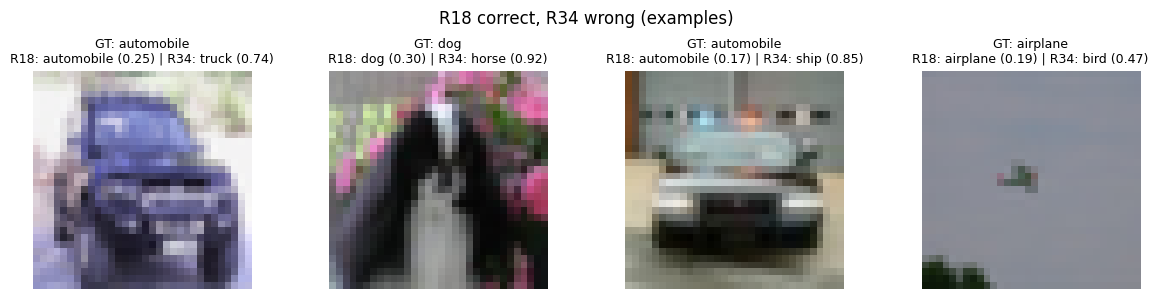

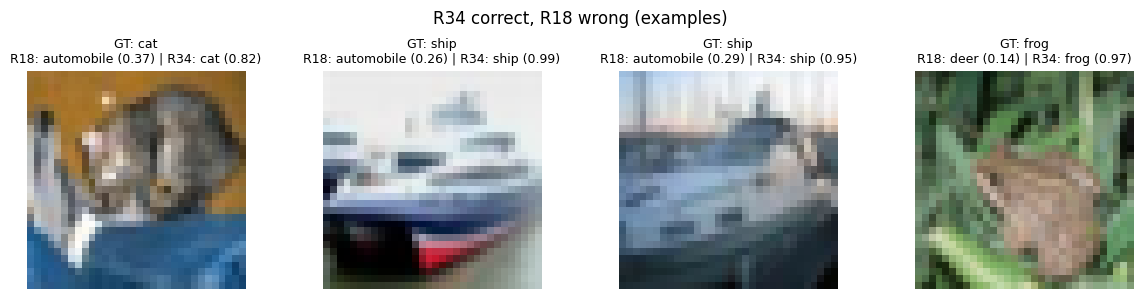

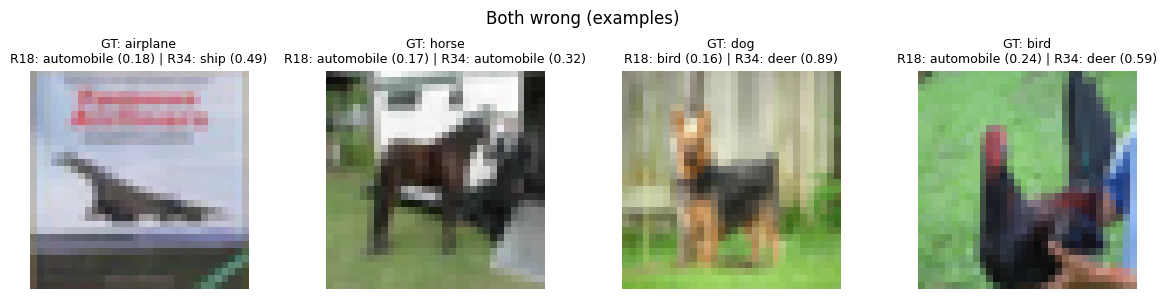

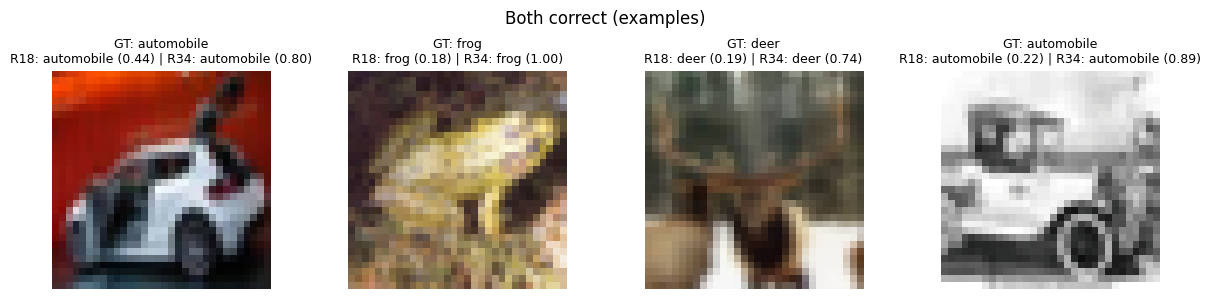

In [26]:
def show_gallery(indices, title, k=12):
    k = min(k, len(indices))
    if k == 0:
        print(f"[{title}] No samples to show.")
        return
    sel = indices[:k]
    cols = 4
    rows = int(np.ceil(k/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for j, idx in enumerate(sel, 1):
        plt.subplot(rows, cols, j)
        plt.imshow(vis_imgs[idx]); plt.axis('off')
        gt = f"GT: {classes[y_true_arr[idx]]}"
        rn18 = f"R18: {classes[r_pred18[idx]]} ({r_conf18[idx]:.2f})"
        rn34 = f"R34: {classes[r_pred34[idx]]} ({r_conf34[idx]:.2f})"
        plt.title(f"{gt}\n{rn18} | {rn34}", fontsize=9)
    plt.suptitle(title)
    plt.tight_layout(); plt.show()

print(f"Counts — both correct={len(idx_both_correct_rn)}, R18✓/R34✗={len(idx_resnet18_only)}, R34✓/R18✗={len(idx_resnet34_only)}, both wrong={len(idx_both_wrong_rn)}, Total={MAX_VIS}")

# [TODO] you need to follow the descriptions to finish TODO
show_gallery(idx_resnet18_only, "R18 correct, R34 wrong (examples)", k=4) # [TODO]
show_gallery(idx_resnet34_only, "R34 correct, R18 wrong (examples)", k=4) # [TODO]
show_gallery(idx_both_wrong_rn, "Both wrong (examples)", k=4) # [TODO]
show_gallery(idx_both_correct_rn, "Both correct (examples)", k=4) # [TODO]

### 15) Top-k high-confidence mistakes
 - For each model, show the mistakes it made with the highest confidence

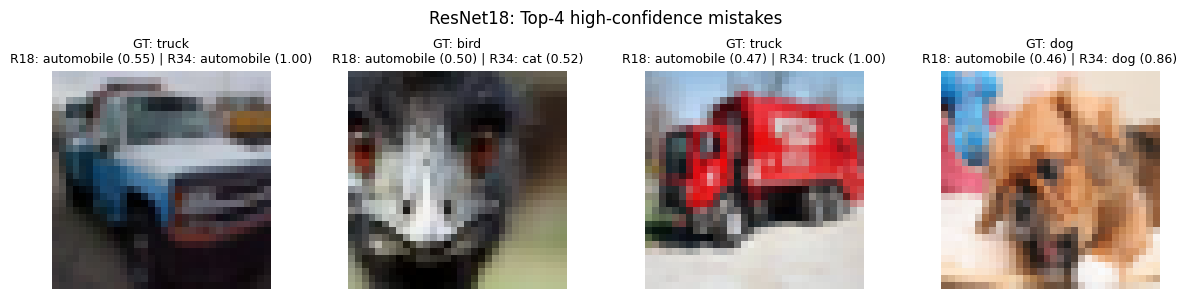

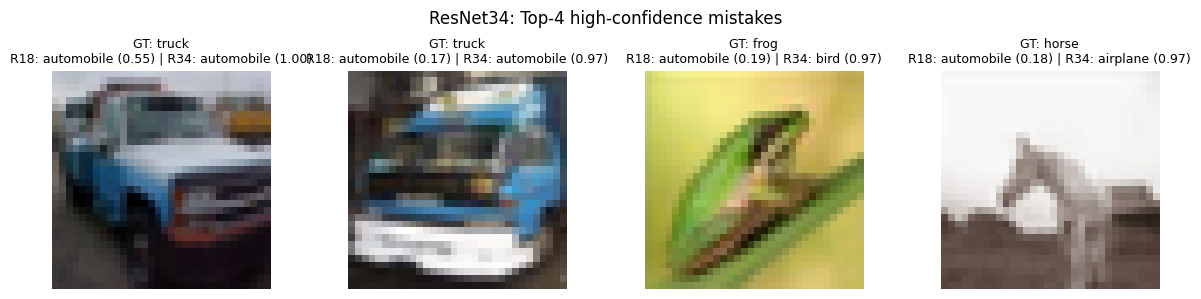

In [27]:
def top_confident_errors(pred, conf, title, k=4):
    wrong = np.where(pred != y_true_arr)[0]
    if len(wrong) == 0:
        print(f"[{title}] No mistakes found.")
        return
    order = wrong[np.argsort(-conf[wrong])]  # descending by confidence
    show_gallery(order, f"{title}: Top-{min(k,len(order))} high-confidence mistakes", k=k)

top_confident_errors(r_pred18, r_conf18, "ResNet18", k=4)
top_confident_errors(r_pred34, r_conf34, "ResNet34", k=4)

### 16) Layer-wise activation overlays
 - ResNet18: conv1 / layer1 / layer2 / layer3 / layer4
 - ResNet34: conv1 / layer1 / layer2 / layer3 / layer4
 - Visualize channel-mean heatmaps over the denormalized image

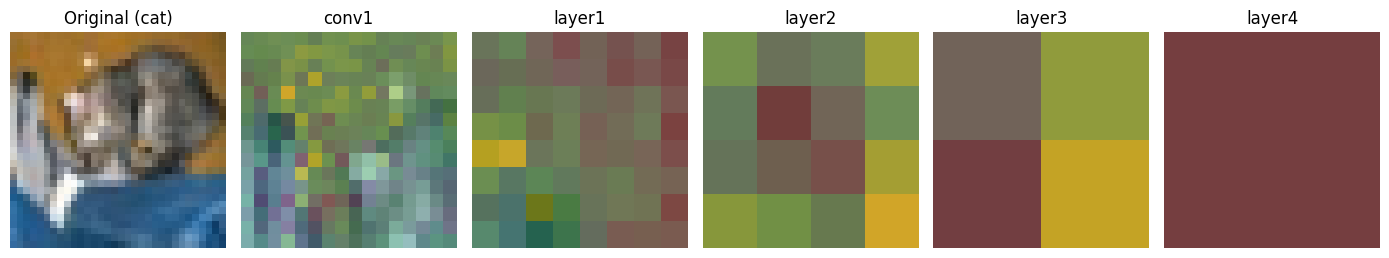

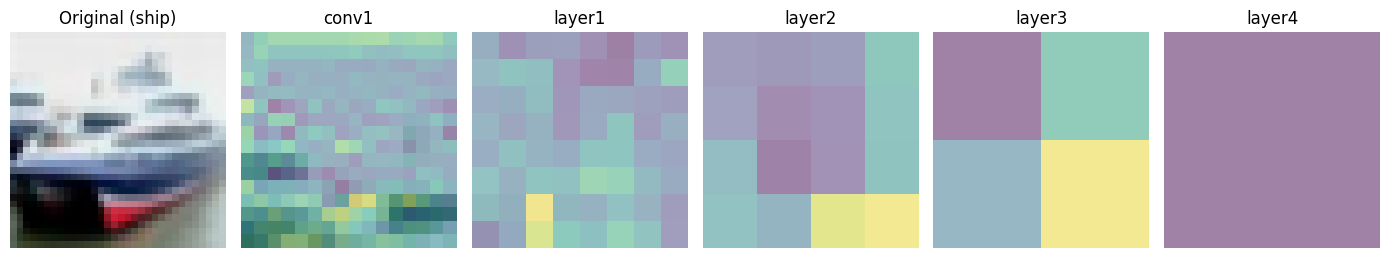

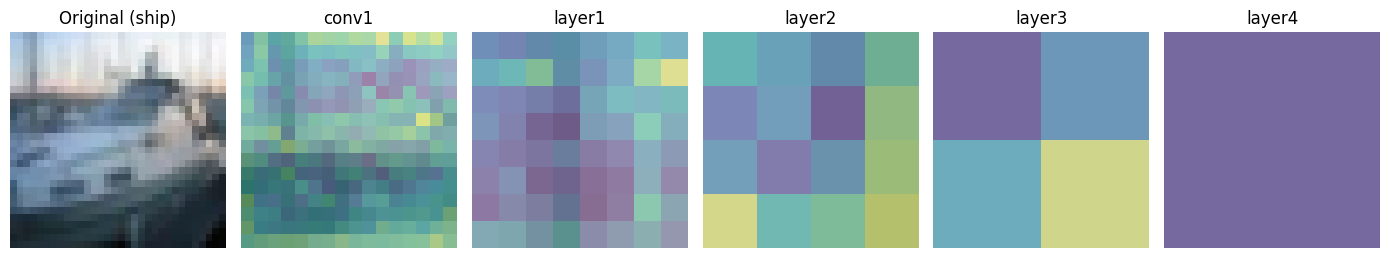

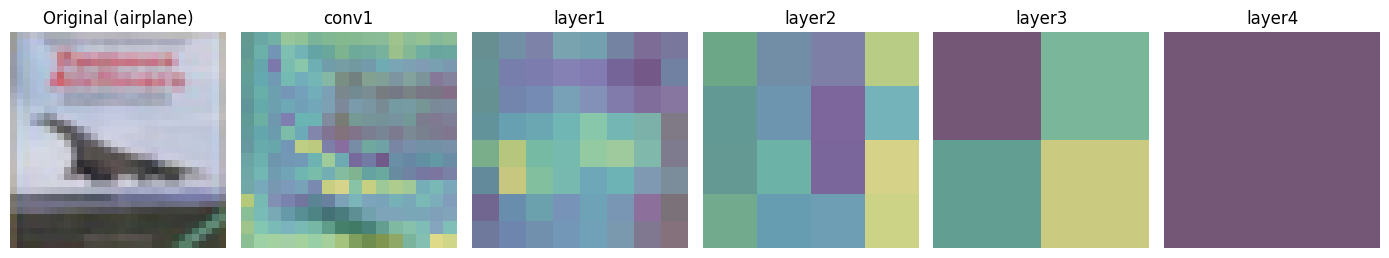

In [28]:
def _norm_map(m):
    m = m - m.min()
    m = m / (m.max() + 1e-6)
    return m

# Use the first N images from the existing test_loader batch (already 224+ImageNet norm)
N_SHOW = 4# [TODO]
first_batch_imgs, first_batch_labels = next(iter(test_loader))
sample_imgs_tensor = first_batch_imgs[:N_SHOW].to(device)

# ----- ResNet18 overlays -----
resnet_nodes  = {"conv1": "R_conv1", "layer1.0.relu": "R_l1", "layer2.0.relu": "R_21", "layer3.0.relu": "R_31", "layer4.0.relu": "R_41"}# [TODO]
resnet_titles = ["conv1","layer1","layer2","layer3","layer4"]
resnet_feat = create_feature_extractor(R18_model, return_nodes=resnet_nodes).to(device).eval()

with torch.no_grad():
    r_feats = resnet_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["R_conv1","R_l1","R_21","R_31","R_41"], start=2):
        fmap = r_feats[key][i].detach().cpu()       # (C,H,W)
        heat = _norm_map(fmap.mean(0)).numpy()      # channel-mean
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(resnet_titles[j-2])
    plt.tight_layout(); plt.show()

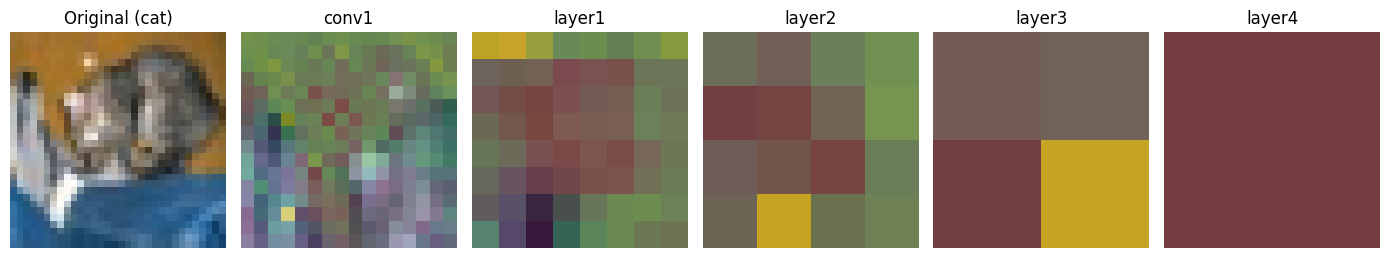

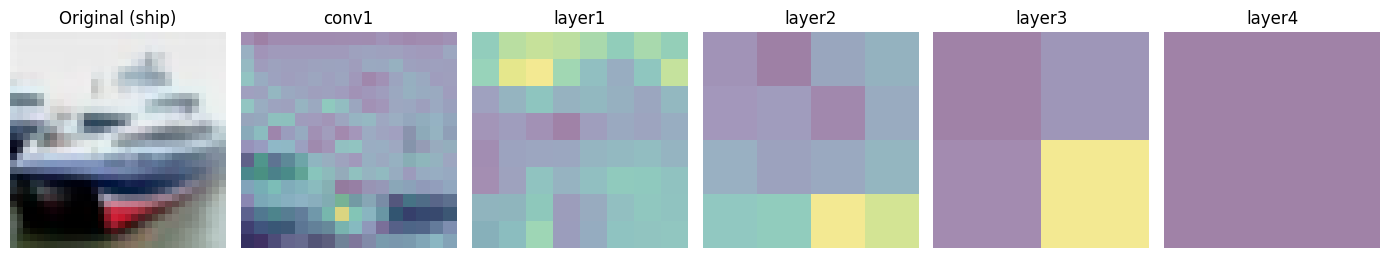

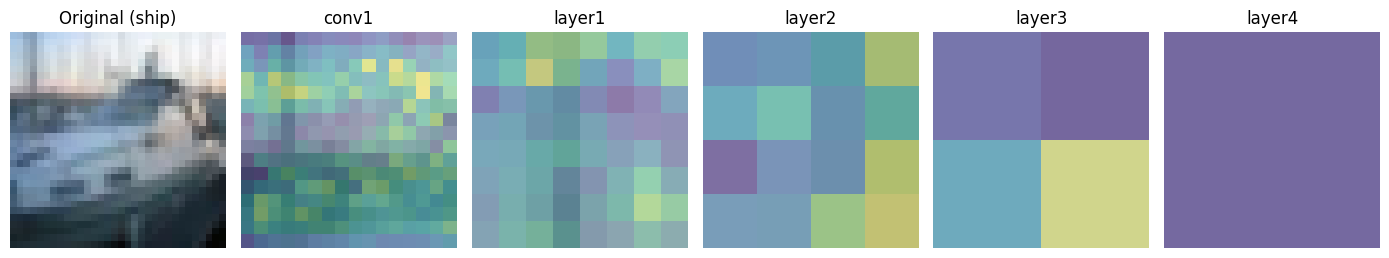

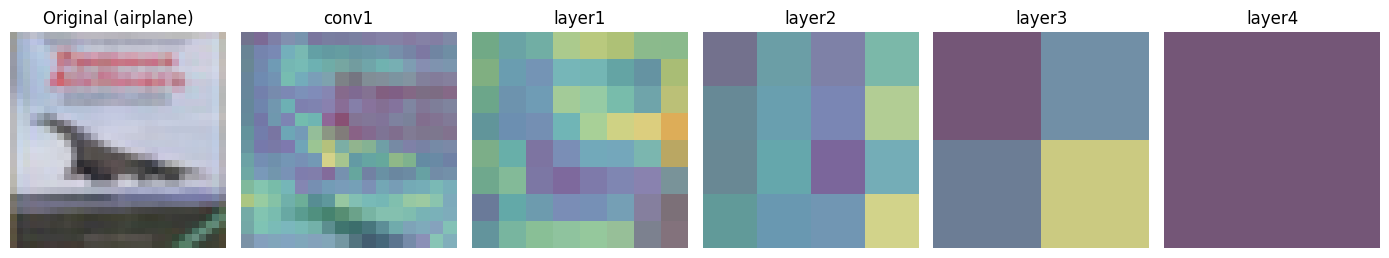

In [29]:
def _norm_map(m):
    m = m - m.min()
    m = m / (m.max() + 1e-6)
    return m

# Use the first N images from the existing test_loader batch (already 224+ImageNet norm)
N_SHOW = 4# [TODO]
first_batch_imgs, first_batch_labels = next(iter(test_loader))
sample_imgs_tensor = first_batch_imgs[:N_SHOW].to(device)

# ----- ResNet34 overlays -----
resnet_nodes  = {"conv1": "R_conv1", "layer1.0.relu": "R_l1", "layer2.0.relu": "R_21", "layer3.0.relu": "R_31", "layer4.0.relu": "R_41"}#{[TODO]}
resnet_titles = ["conv1","layer1","layer2","layer3","layer4"]
resnet_feat = create_feature_extractor(R34_model, return_nodes=resnet_nodes).to(device).eval()

with torch.no_grad():
    r_feats = resnet_feat(sample_imgs_tensor)

for i in range(N_SHOW):
    img_den = denorm(sample_imgs_tensor[i]).permute(1,2,0).detach().cpu().numpy()
    plt.figure(figsize=(14,3))
    plt.subplot(1, 6, 1); plt.imshow(img_den); plt.axis('off');
    plt.title(f"Original ({classes[first_batch_labels[i]]})")
    for j, key in enumerate(["R_conv1","R_l1","R_21","R_31","R_41"], start=2):
        fmap = r_feats[key][i].detach().cpu()       # (C,H,W)
        heat = _norm_map(fmap.mean(0)).numpy()      # channel-mean
        plt.subplot(1, 6, j)
        plt.imshow(img_den)
        plt.imshow(heat, alpha=0.45)
        plt.axis('off'); plt.title(resnet_titles[j-2])
    plt.tight_layout(); plt.show()

# Summary
We compare the performance of ResNet-18 and ResNet-34 on CIFAR-10 after fine-tuning and analyze their characteristics.

1. **Setup and Data Loading**: Installed necessary packages, downloaded a pre-trained ResNet-18 checkpoint, imported libraries, set up configurations and seeds, and loaded and preprocessed the CIFAR-10 dataset.

2. **ResNet Implementation**: Implemented the BasicBlock and ResNet classes from scratch, following the ResNet architecture.

3. **ResNet-34 Fine-tuning**: Loaded a pre-trained ResNet-34 model, modified the final fully connected layer for CIFAR-10 classification, set up the optimizer, scheduler, and criterion, and trained the model for 3 epochs.

4. **Evaluation and Analysis (ResNet-34)**: Evaluated the fine-tuned ResNet-34 model, plotted the loss curve, generated precision-recall curves and a classification report, and visualized the confusion matrix.

5. **ResNet-18 Evaluation**: Loaded the pre-trained ResNet-18 checkpoint and evaluated its performance on the CIFAR-10 test set.
Model Comparison: Compared the ResNet-18 and fine-tuned ResNet-34 models based on parameters, test accuracy, and inference speed.

6. **Qualitative Analysis**: Generated a gallery of images to compare the predictions of both models, including cases where both were correct, one was correct and the other wrong, and both were wrong. Also visualized top high-confidence mistakes for each model.

7. **Feature Map Visualization**: Visualized the channel-mean heatmaps of feature maps from different layers of both ResNet-18 and ResNet-34 models to understand their learned representations.

## Key Findings
*Only based on our current implementation:

* **ResNet34 Performance**: The fine-tuned ResNet-34 model achieved a test accuracy of 77.33% on CIFAR-10 after 3 epochs of training.
* **ResNet18 Performance**: The loaded ResNet-18 checkpoint achieved a test accuracy of 16.92%. This is significantly lower than ResNet34.
* **Model Comparison**:
  * ResNet34 has more parameters (21.29 M) compared to ResNet18 (11.18 M, from the summary output in cell 1WDFJzvyf9ZA).
  * ResNet34 achieved a much higher test accuracy (77.33%) than ResNet18 (16.92%).
  * The inference speed is very similar between the two models (around 0.39 ms/img).
* **Qualitative Analysis**: The divergent sample gallery and top confident errors visualization show that ResNet34 is generally better at classifying images, with fewer high-confidence mistakes and more instances where it is correct while ResNet18 is wrong.
* **Feature Map Visualization**: The feature maps show how the models process the input images at different layers, providing some visual insight into what features are being learned.

In summary, the fine-tuned ResNet-34 model significantly outperforms the ResNet-18 model on the CIFAR-10 dataset in terms of accuracy, while maintaining a similar inference speed. This suggests that for this task and training setup, the larger ResNet-34 architecture is more effective.